In [16]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lib.bandits import Gaussian
from lib.policies import RoundRobin, GEGE
from lib.utils import (Delta_i, is_non_dominated,
                       run_batch_seeds)
r""" IMPORTANT
Comments the next import statement if the cpp code has not been successfully imported
"""
from cxx.policies import (py_ege_sr as EGE_SR_CPP,
                          py_ege_sh as EGE_SH_CPP,
                          py_batch_sr, py_batch_sh)

In [2]:
# load data
ds_real = pd.read_csv("./data/noc_CM_log.csv", sep=";")
arr = ds_real.to_numpy()
X = arr[:, :4]
Y = arr[:, 4:]
X = X/np.linalg.norm(X, axis=-1)[:, None] # normalize features
V_r = X.T @ X
# linear approximation of the regression parameter
Theta  = np.linalg.lstsq(X.T @ X, X.T @ Y, rcond =-1)[0]

In [3]:
# load bandit instance
delta = 0.1
K = arr.shape[0]
arms = np.arange(K)
df = 4 #number of features
dv = 2 # number of dimensions
D= dv
arms_means = -X @ Theta # max instead of min
S_star_mask = is_non_dominated(arms_means)
S_star = set(S_star_mask.nonzero()[0])
S_star_comp = set((~S_star_mask).nonzero()[0])
bandit = Gaussian(arms_means=arms_means, stddev=np.ones(dv)*0.5)

#### Fixed-budget setting

In [4]:
numrep = 150
numtps = 10
T_min = int(K*np.ceil(np.log2(K)))
T_max = 2*int(bandit.H/2 +1) + 1
seeds = (np.random.uniform(size=numrep)*2**31).astype(int)
T_range = np.linspace(T_min, T_max, numtps).astype(int)

In [5]:
# algo in the fixed-budget setting
gege_fb = GEGE(bandit, X)
ege_sh  = EGE_SH_CPP(bandit)
ege_sr  = EGE_SR_CPP(bandit)
unif_fb = RoundRobin(bandit)

#### Run the algorithms

In [6]:
res_ege_sh = np.array(py_batch_sh(bandit, T_range, seeds))
res_ege_sr = np.array(py_batch_sr(bandit, T_range, seeds))
res_unif = np.array([run_batch_seeds(seeds, T, unif_fb.loop) for T in T_range])

In [7]:
res_gege_fb = np.array([run_batch_seeds(seeds,T, gege_fb.loop_fb) for T in T_range])

#### Plot the results

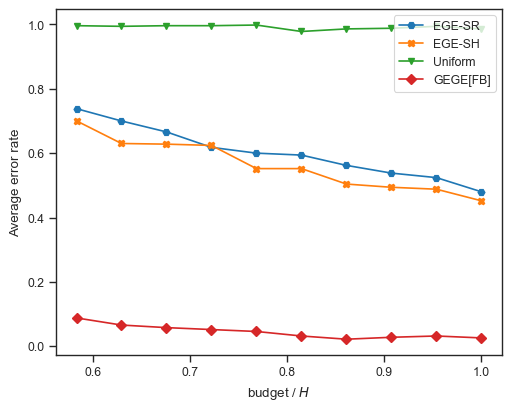

In [15]:
sns.set_style("ticks")
sns.set_context("paper")
sns.color_palette("viridis")
f = plt.figure(figsize=(5, 4), layout='constrained')
#plt.figure(layout='constrained')
plt.xlabel(r"budget / $H$")
#plt.xlabel(r"budget $T$")
plt.ylabel(r"Average error rate")
x = T_range  / bandit.H
plt.plot(x, (1-res_ege_sr.mean(-1)), marker="H", label="EGE-SR")
plt.plot(x, (1-res_ege_sh.mean(-1)), marker="X", label="EGE-SH")
plt.plot(x, (1-res_unif.mean(-1)), marker="v", label="Uniform")
plt.plot(x, (1-res_gege_fb.mean(-1)), marker="D", label="GEGE[FB]")
markers = ["v", "d", "<"]
plt.legend(fancybox=True, loc="upper right")
plt.savefig("../figs/nocFbnips.pdf", transparent=True, dpi=1600)